<a href="https://www.kaggle.com/code/akifkara217/global-ai-hub-ann-project?scriptVersionId=202555298" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Required Libraries

First of all, I imported the necessary libraries in the project.

In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



# 2. Preparation of Data Path and Files

The dataset consists of photos in .png format located in folders. Therefore, we cannot read them with pd.read_csv as we do in ML applications. Therefore, it is necessary to organize this data and create a Pandas DataFrame.

In [2]:
# Path for dataset
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset'

# Collect files and tags
label = []
path = []

for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':  # If the file is png
            if dir_name.split('/')[-1] != 'GT':  # If the folder does not contain GT
                label.append(os.path.split(dir_name)[-1])  # Get folder name as label
                path.append(os.path.join(dir_name, filename))  # Save file path

# Creating a Pandas DataFrame
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

# Let's examine the data
print(data.head())


                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel


# 3. Separating Training, Validation, and Test Data

I separated the training and test data. I also separated some of the training data for validation data.

In [3]:
# Split the data into training and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Split a portion of the training data for validation
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['label'])


# 4. Data Loading and Augmentation (Data Enrichment)

In order to use the repeat() function, I created the dataset with tf.data.Dataset. I created a TensorFlow dataset to read image data, preprocess it, and convert its classes into one-hot encoding format, and prepared this dataset appropriately for training, validation, and testing phases, ensuring it was grouped.

In [4]:
# Set batch size
batch_size = 32
image_size = (128, 128)

# Create dataset using tf.data.Dataset
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = image / 255.0
    return image, label

# Convert labels to one-hot encoding
def one_hot_label(label, class_names):
    one_hot = tf.equal(class_names, label)
    return tf.cast(one_hot, tf.float32)

# Create dataset
def create_dataset(data, class_names, augment=False):
    image_paths = data['path'].values
    labels = data['label'].values
    labels = [one_hot_label(label, class_names) for label in labels]
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y))

    if augment:
        # Data augmentation process
        dataset = dataset.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
        dataset = dataset.map(lambda x, y: (tf.image.random_brightness(x, max_delta=0.2), y))

    dataset = dataset.shuffle(buffer_size=len(data))
    dataset = dataset.batch(batch_size)
    return dataset

# Class names
class_names = sorted(train_data['label'].unique())

# Create datasets
train_dataset = create_dataset(train_data, class_names, augment=True).repeat()
val_dataset = create_dataset(val_data, class_names).repeat()
test_dataset = create_dataset(test_data, class_names)


# 5. Creating the Model

I created a neural network model (Artificial Neural Network - ANN) using TensorFlow's Keras API, which consists of several layers including input, flattening, fully connected layers, dropout layers for regularization, and an output layer with softmax activation for classification, and then compiled it with an Adam optimizer and categorical crossentropy loss, incorporating early stopping to prevent overfitting.

In [5]:
# Create model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(128, 128, 3)),  # Input dimensions
    tf.keras.layers.Flatten(),  # Flatten the image
    tf.keras.layers.Dense(512, activation='relu'),  # Fully connected layer
    tf.keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(256, activation='relu'),  # Additional Dense layer
    tf.keras.layers.Dense(len(class_names), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Use early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# 6. Training the Model


In this code, the steps_per_epoch and validation_steps are calculated based on the lengths of the training and validation datasets divided by the batch size, and then the model is trained using the fit method for 20 epochs with early stopping to prevent overfitting, while handling any potential errors that may occur during the training process.

In [6]:
# Calculate steps_per_epoch and validation_steps
steps_per_epoch = len(train_data) // batch_size
validation_steps = len(val_data) // batch_size

print("Train steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

# Train the model
try:
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        epochs=20,
        callbacks=[early_stopping]
    )
except Exception as e:
    print("Error:", e)


Train steps per epoch: 360
Validation steps: 90
Epoch 1/20


I0000 00:00:1729550566.350924      67 service.cc:145] XLA service 0x7a6f04005300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729550566.350987      67 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729550566.350992      67 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 18/360 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0990 - loss: 3.3039

I0000 00:00:1729550569.267916      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


360/360 ━━━━━━━━━━━━━━━━━━━━ 66s 55ms/step - accuracy: 0.1776 - loss: 2.6313 - val_accuracy: 0.3316 - val_loss: 1.8494
Epoch 2/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.2886 - loss: 2.0204 - val_accuracy: 0.4219 - val_loss: 1.6465
Epoch 3/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.3454 - loss: 1.8226 - val_accuracy: 0.4490 - val_loss: 1.5327
Epoch 4/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.3823 - loss: 1.6888 - val_accuracy: 0.5024 - val_loss: 1.3816
Epoch 5/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.4063 - loss: 1.6168 - val_accuracy: 0.5174 - val_loss: 1.3230
Epoch 6/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.4204 - loss: 1.5512 - val_accuracy: 0.5510 - val_loss: 1.2444
Epoch 7/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.4502 - loss: 1.4859 - val_accuracy: 0.5757 - val_loss: 1.1920
Epoch 8/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.4663 - loss: 1.4210 - val_accurac

# 7. Loss and Accuracy Graphs


I had the Loss and Accuracy graphs drawn in this section so I could more easily observe whether the model was overfit or not.

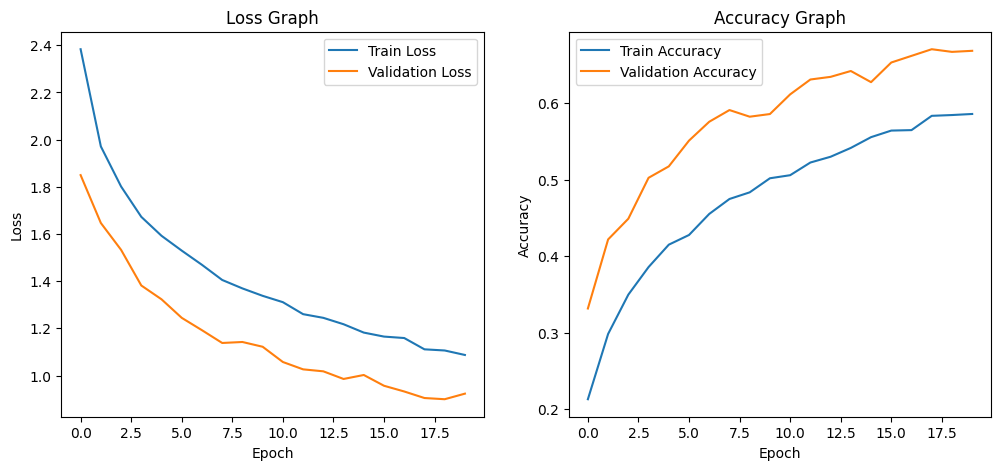

In [7]:
plt.figure(figsize=(12, 5))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# 8. Success on the Test Set

In [8]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")


113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.6846 - loss: 0.8916
Test Accuracy: 0.6844


# 9. Additional Images

Viewing the First 10 Observations

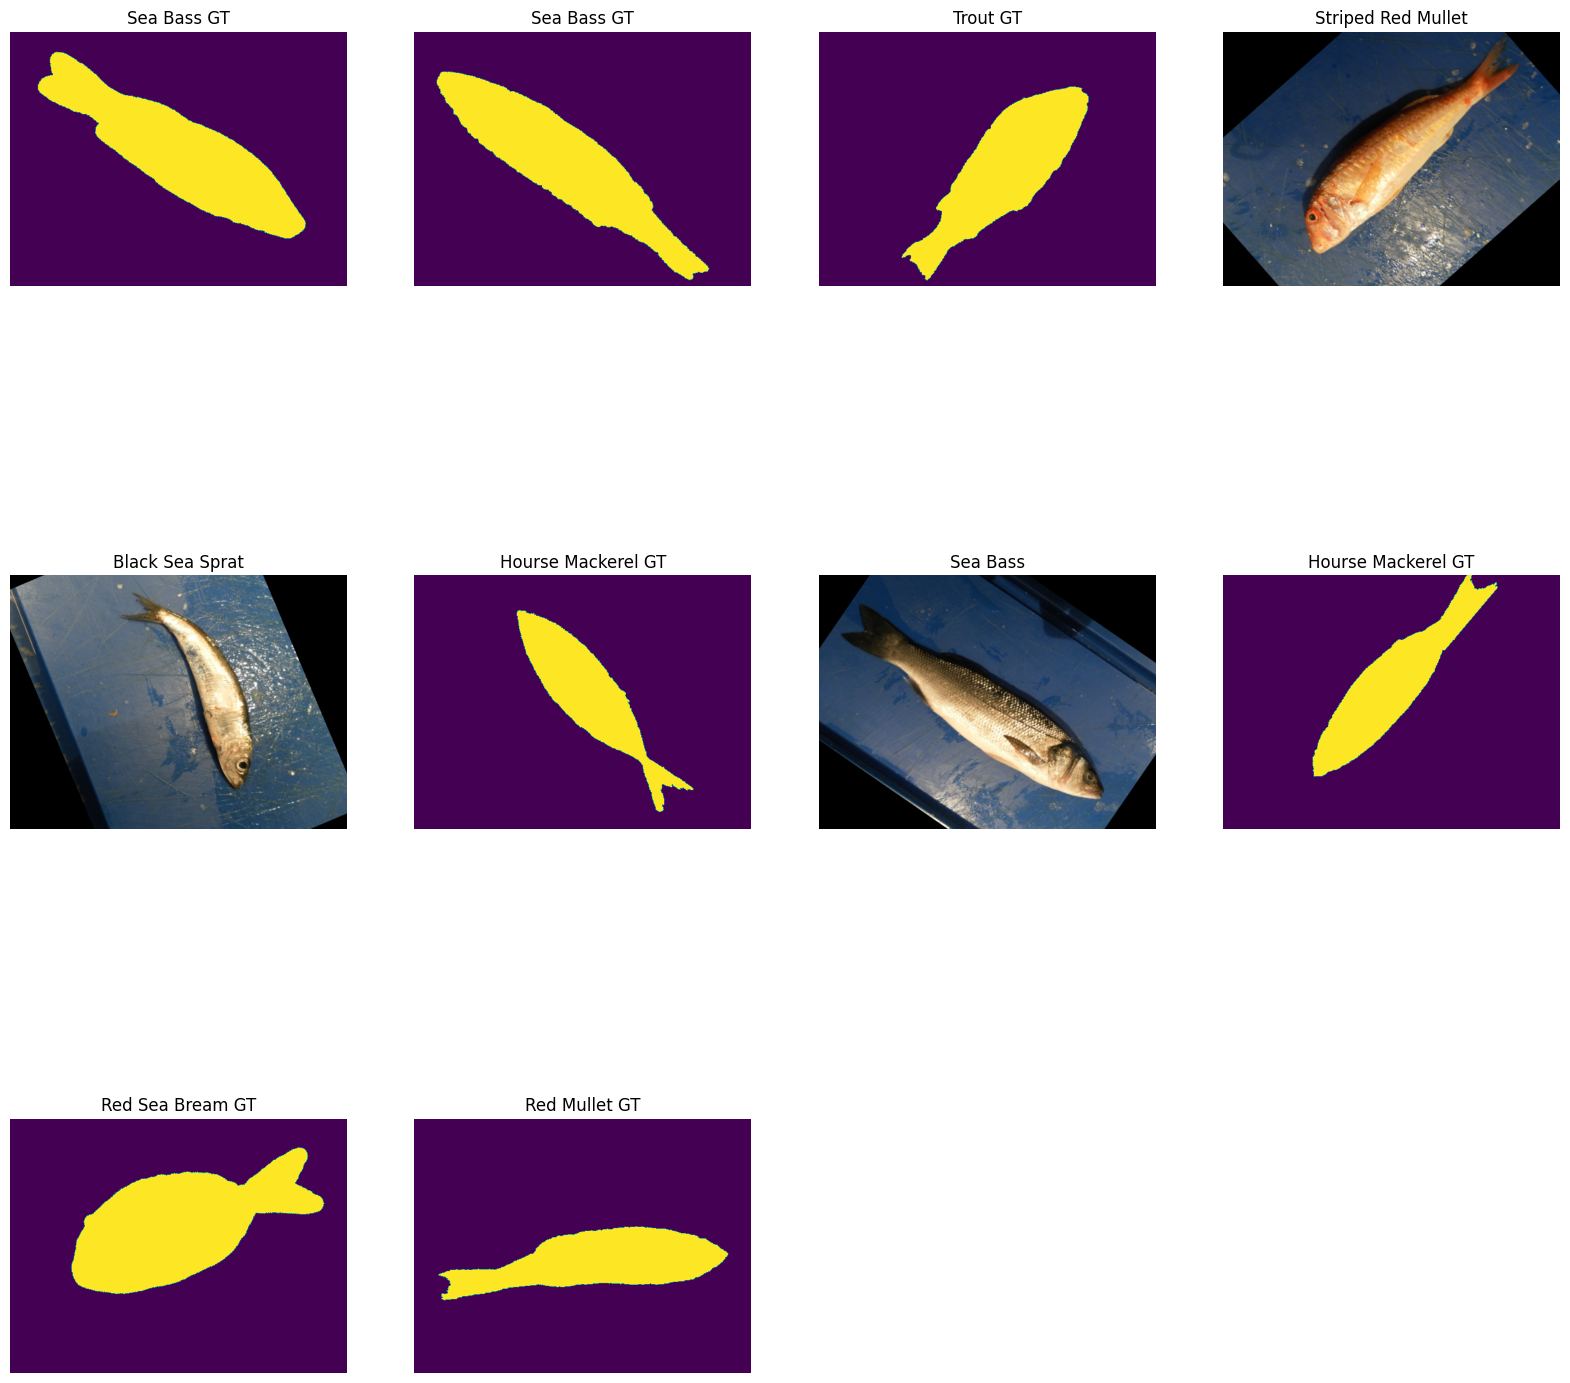

In [9]:
import matplotlib.pyplot as plt

cn = 0
plt.figure(figsize=(20, 20))

# Loop to get the first 10 images and their labels
for i in range(10):
    img_path = train_data.iloc[i]['path']  # Image path
    img_label = train_data.iloc[i]['label']  # Image label
    
    # Display the image
    plt.subplot(3, 4, cn + 1)  # Create a grid with 3 rows and 4 columns
    plt.imshow(plt.imread(img_path))
    plt.title(img_label)  # Add the label as the title
    plt.axis('off')  # Turn off the axes
    cn += 1

plt.show()


Pixel Density Review

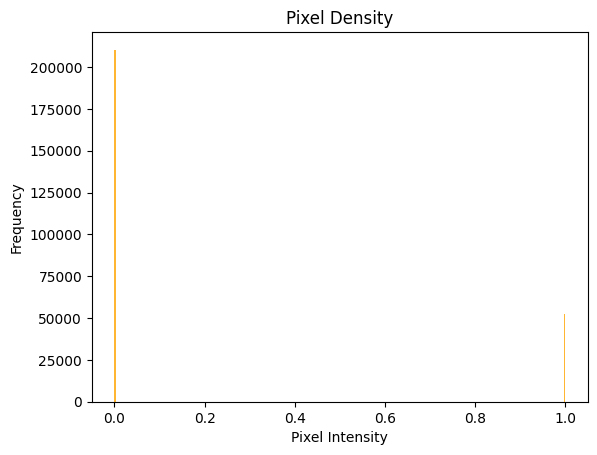

In [10]:
import numpy as np

# Let's examine the pixel intensity of the first image
first_image = plt.imread(train_data.iloc[0]['path'])
plt.hist(first_image.ravel(), bins=256, color='orange', alpha=0.8)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Density')
plt.show()



Class Distribution Visualization

label
Hourse Mackerel          1000
Hourse Mackerel GT       1000
Black Sea Sprat GT       1000
Black Sea Sprat          1000
Sea Bass                 1000
Sea Bass GT              1000
Red Mullet               1000
Red Mullet GT            1000
Trout                    1000
Trout GT                 1000
Striped Red Mullet GT    1000
Striped Red Mullet       1000
Shrimp GT                1000
Shrimp                   1000
Gilt-Head Bream GT       1000
Gilt-Head Bream          1000
Red Sea Bream            1000
Red Sea Bream GT         1000
Name: count, dtype: int64
                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel


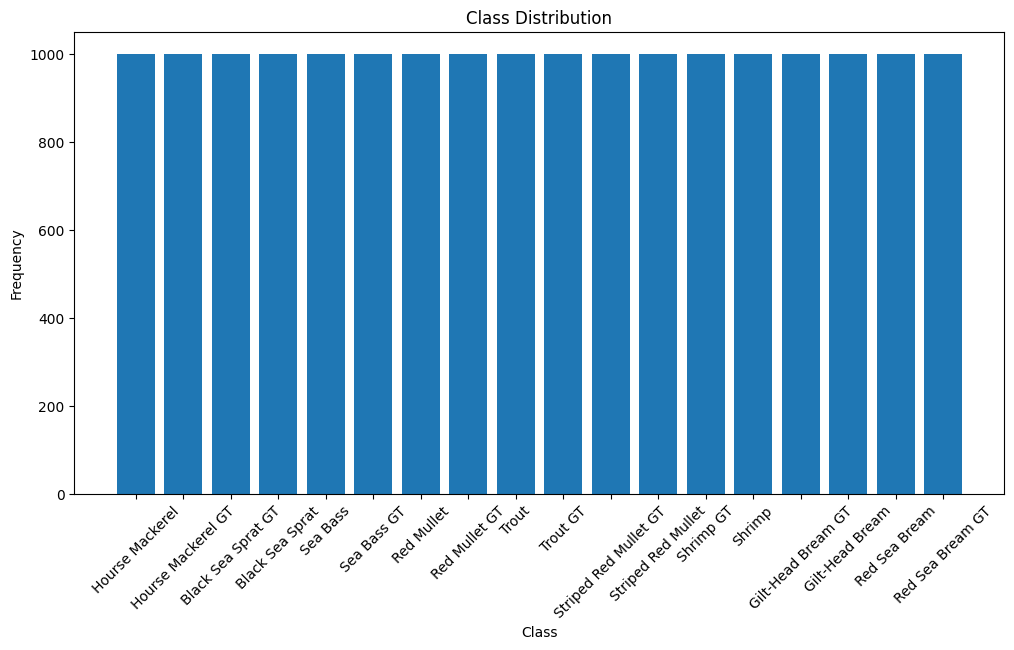

In [11]:
# Class distribution
print(data['label'].value_counts())
print(data.head())
plt.figure(figsize=(12, 6))  # Set the size of the graph

class_counts = data['label'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
